# Лабораторная работа 3.5.1. Изучение плазмы газового разряда в неоне

### Цель работы

Целью данной работы является исследование основных свойств плазмы тлеющего газового разряда в неоне. В ходе работы необходимо:
1. Снять вольт-амперную характеристику (ВАХ) газового разряда.
2. Снять зондовые характеристики для двойного зонда при различных токах разряда.
3. По полученным данным рассчитать ключевые параметры плазмы: температуру электронов ($T_e$), концентрацию электронов ($n_e$), дебаевский радиус экранирования ($r_D$), плазменную частоту ($\omega_p$) и число частиц в сфере Дебая ($N_D$).

### Теоретическая справка

#### Плазма и ее свойства

Плазма — это частично или полностью ионизированный газ, в котором концентрации положительных и отрицательных зарядов практически совпадают, что делает его в целом квазинейтральным. Из-за теплового движения электроны могут смещаться относительно более тяжелых ионов, создавая локальные электрические поля. Эти поля стремятся восстановить равновесие, что приводит к коллективным колебаниям электронов с плазменной (ленгмюровской) частотой:

$$ \omega_p = \sqrt{\frac{n_e e^2}{\varepsilon_0 m_e}} $$

где $n_e$ — концентрация электронов, $e$ — элементарный заряд, $m_e$ — масса электрона, а $\varepsilon_0$ — диэлектрическая проницаемость вакуума.

Если в плазму поместить точечный заряд, его поле будет экранировано окружающими заряженными частицами. Характерный масштаб, на котором происходит экранирование, называется **дебаевским радиусом**:

$$ r_D = \sqrt{\frac{\varepsilon_0 k_B T_e}{n_e e^2}} $$

где $k_B$ — постоянная Больцмана, $T_e$ — температура электронов. Условием существования плазмы как идеальной системы является большое число частиц в сфере с дебаевским радиусом ($N_D \gg 1$):

$$ N_D = \frac{4}{3}\pi r_D^3 n_e $$

#### Метод двойного зонда

Для диагностики плазмы широко используется зондовый метод. В данной работе применяется **двойной зонд** — система из двух одинаковых электродов, на которые подается небольшая разность потенциалов $U$. Вся система "плавает" относительно потенциала плазмы, то есть ее суммарный ток на плазму равен нулю.

Теоретическая вольт-амперная характеристика (ВАХ) симметричного двойного зонда описывается выражением:

$$ I(U) = I_{i, sat} \cdot \tanh\left(\frac{eU}{2k_B T_e}\right) $$

где $I_{i, sat}$ — ионный ток насыщения.

Из этой формулы видно, что при малых напряжениях ($U \to 0$) зависимость $I(U)$ близка к линейной. Наклон характеристики в этой точке позволяет определить температуру электронов:

$$ \left. \frac{dI}{dU} \right|_{U=0} = \frac{I_{i, sat} \cdot e}{2k_B T_e} \implies T_e = \frac{e}{2k_B} \frac{I_{i, sat}}{\left. \frac{dI}{dU} \right|_{U=0}} $$

Ионный ток насыщения $I_{i, sat}$ определяется по выходу ВАХ на плато при больших напряжениях $U$. Зная $I_{i, sat}$ и $T_e$, можно найти концентрацию электронов $n_e$ с помощью эмпирической формулы Бома:

$$ I_{i, sat} = 0.4 \cdot e \cdot n_e \cdot S \cdot \sqrt{\frac{2k_B T_e}{m_i}} $$

где $S$ — площадь поверхности одного зонда, $m_i$ — масса иона (в нашем случае неона-22).

### Экспериментальная установка
В работе используется стеклянная газоразрядная трубка, наполненная изотопом неона ($^{22}$Ne). Разряд зажигается между катодом и одним из анодов. Диагностика плазмы производится с помощью двойного зонда, расположенного в области положительного столба разряда.

**Параметры зонда:**
- Материал: молибденовая проволока
- Диаметр: $d = 0.2$ мм
- Длина: $l = 5.2$ мм

**Измерительные приборы:**
- Мультиметр: GW Instek GDM-8245
- Источник питания: GPS-1303

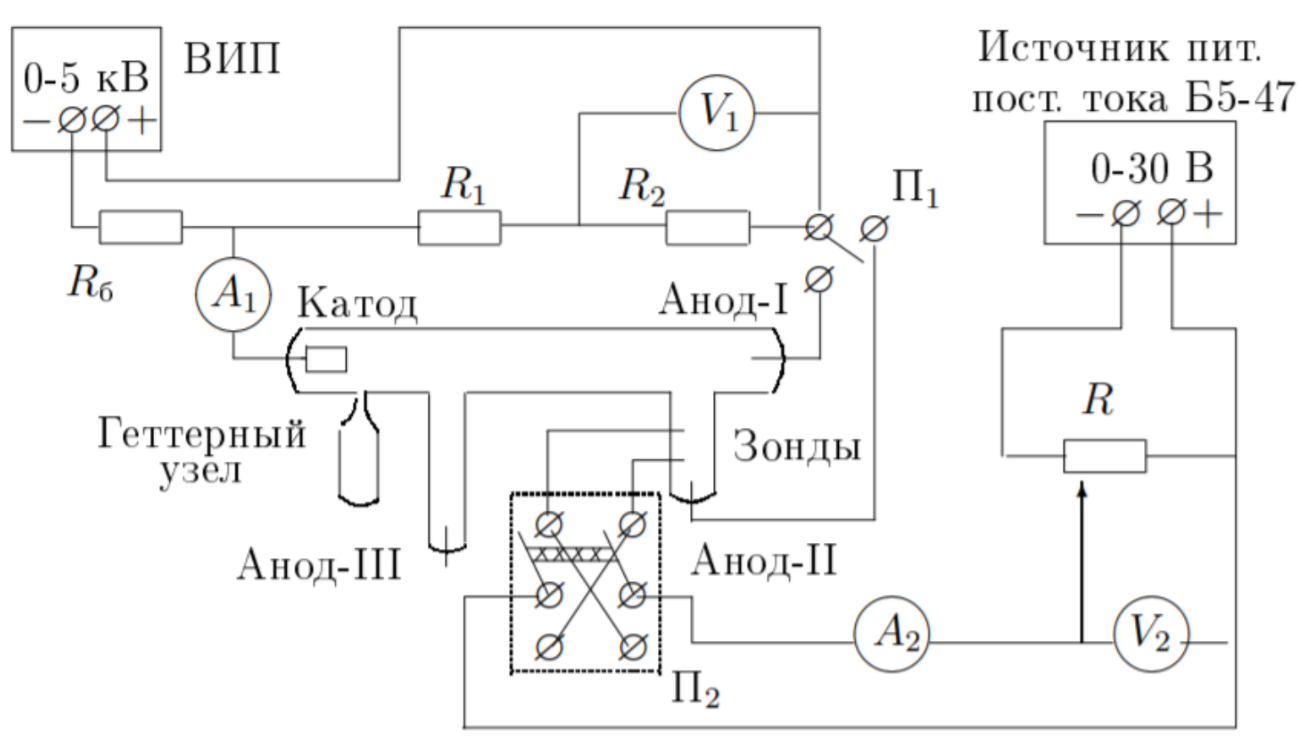

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import display, HTML

# --- Константы ---
e = 1.602e-19  # Элементарный заряд, Кл
k_b = 1.381e-23 # Постоянная Больцмана, Дж/К
m_e = 9.109e-31 # Масса электрона, кг
m_i = 22 * 1.661e-27 # Масса иона неона-22, кг
epsilon_0 = 8.854e-12 # Диэлектрическая проницаемость вакуума, Ф/м

# --- Параметры зонда ---
d_probe = 0.2e-3  # Диаметр зонда, м
l_probe = 5.2e-3  # Длина зонда, м
S_probe = np.pi * d_probe * l_probe # Площадь поверхности одного зонда, м^2

print(f"Площадь поверхности зонда S = {S_probe:.3e} м^2")

# --- Функции для расчета погрешностей мультиметра GDM-8245 ---
# Погрешность измерения напряжения (DCV)
def voltage_error(value, range_max=200): # Используем диапазон 200В для разряда, 20В для зонда
    # Спецификация: ±(0.05% от показания + 5 единиц младшего разряда)
    if abs(value) <= 20:
        resolution = 0.001
    else:
        resolution = 0.01
    return 0.0005 * abs(value) + 5 * resolution

# Погрешность измерения тока (DCA)
def current_error_mA(value):
    # Диапазон 200 мА: ±(0.2% от показания + 10 единиц)
    resolution = 0.01
    return 0.002 * abs(value) + 10 * resolution

def current_error_uA(value):
    # Диапазон 2000 мкА: ±(0.1% от показания + 5 единиц)
    resolution = 0.1
    return 0.001 * abs(value) + 5 * resolution

# Стиль графиков
plt.style.use('seaborn-v0_8-whitegrid')

Площадь поверхности зонда S = 3.267e-06 м^2


### Ход работы и обработка результатов

#### 1. Вольт-амперная характеристика газового разряда

Сначала была снята зависимость напряжения на разрядной трубке ($U_p$) от тока разряда ($I_p$). Измерения проводились при увеличении тока ("Вверх") и при его уменьшении ("Вниз").

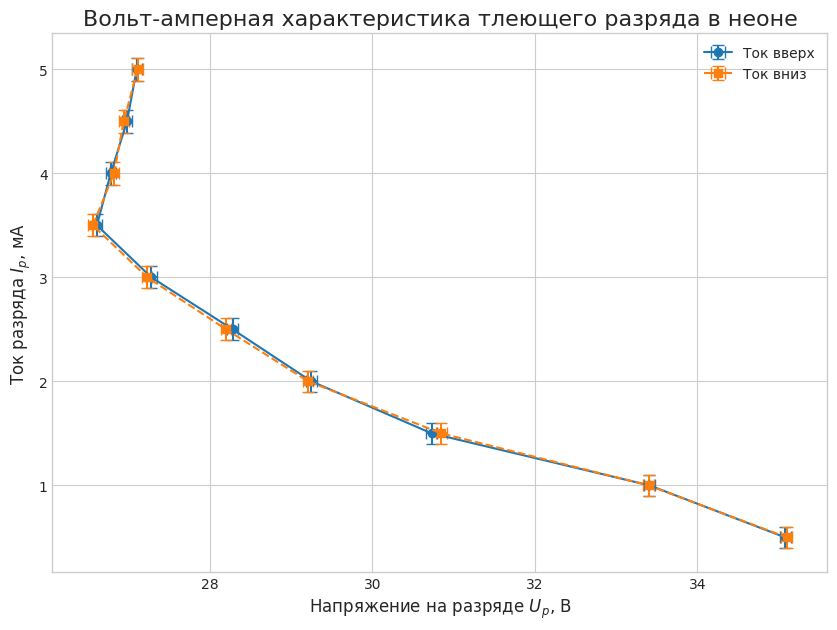

In [2]:
# --- Данные для ВАХ разряда ---
data_discharge_up = {
    'I_p_mA': [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0],
    'U_p_V': [35.08, 33.41, 30.73, 29.25, 28.28, 27.28, 26.61, 26.78, 26.98, 27.10]
}
df_up = pd.DataFrame(data_discharge_up)
df_up['I_err'] = df_up['I_p_mA'].apply(current_error_mA)
df_up['U_err'] = df_up['U_p_V'].apply(voltage_error)

data_discharge_down = {
    'I_p_mA': [5.0, 4.5, 4.0, 3.5, 3.0, 2.5, 2.0, 1.5, 1.0, 0.5],
    'U_p_V': [27.11, 26.94, 26.82, 26.56, 27.23, 28.20, 29.21, 30.85, 33.4, 35.10]
}
df_down = pd.DataFrame(data_discharge_down)
df_down['I_err'] = df_down['I_p_mA'].apply(current_error_mA)
df_down['U_err'] = df_down['U_p_V'].apply(voltage_error)

# --- Построение графика ВАХ разряда ---
plt.figure(figsize=(10, 7))
plt.errorbar(df_up['U_p_V'], df_up['I_p_mA'], xerr=df_up['U_err'], yerr=df_up['I_err'],
             fmt='o-', capsize=4, label='Ток вверх')
plt.errorbar(df_down['U_p_V'], df_down['I_p_mA'], xerr=df_down['U_err'], yerr=df_down['I_err'],
             fmt='s--', capsize=4, label='Ток вниз')

plt.title('Вольт-амперная характеристика тлеющего разряда в неоне', fontsize=16)
plt.xlabel('Напряжение на разряде $U_p$, В', fontsize=12)
plt.ylabel('Ток разряда $I_p$, мА', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

Из графика видно, что ВАХ имеет падающий участок, что характерно для поднормального тлеющего разряда. Также наблюдается небольшой гистерезис: кривые, снятые при увеличении и уменьшении тока, не совпадают полностью.


#### 2. Зондовые характеристики

Далее были сняты вольт-амперные характеристики двойного зонда при двух фиксированных значениях тока разряда: $I_p = 3.0$ мА и $I_p = 1.5$ мА. Для каждого случая измерялся ток через зонд ($I_з$) в зависимости от напряжения между щупами зонда ($U_з$).

In [3]:
# --- Данные зондовых измерений ---

# I_p = 3 мА
data_probe_3mA = {
    'U_z_V': [-25, -22, -19, -16, -13, -10, -8, -6, -4, -2, 2, 4, 6, 8, 10, 13, 16, 19, 22, 25],
    'I_z_uA': [-67.73, -65.82, -63.65, -61.14, -56.98, -50.17, -43.91, -35.62, -25.33, -13.62,
               13.62, 25.33, 35.62, 43.91, 50.17, 56.98, 61.14, 63.65, 65.82, 67.73]
}
# Данные в тетради симметричны, используем положительную ветвь и отразим
I_z_uA_3mA_pos = [13.62, 25.33, 35.62, 43.91, 50.17, 56.98, 61.14, 63.65, 65.82, 67.73]
I_z_uA_3mA_neg = [-x for x in reversed(I_z_uA_3mA_pos)]
U_z_V_3mA_pos = [2, 4, 6, 8, 10, 13, 16, 19, 22, 25]
U_z_V_3mA_neg = [-x for x in reversed(U_z_V_3mA_pos)]

df_3mA = pd.DataFrame({
    'U_z_V': U_z_V_3mA_neg + U_z_V_3mA_pos,
    'I_z_uA': I_z_uA_3mA_neg + I_z_uA_3mA_pos
})
df_3mA['U_err'] = df_3mA['U_z_V'].apply(voltage_error)
df_3mA['I_err'] = df_3mA['I_z_uA'].apply(current_error_uA)


# I_p = 1.5 мА
data_probe_1_5mA = {
    'U_z_V': [-25, -22, -19, -16, -13, -10, -8, -6, -4, -2, 2, 4, 6, 8, 10, 13, 16, 19, 22, 25],
    'I_z_uA': [-33.58, -32.44, -31.31, -30.11, -28.32, -25.11, -21.34, -17.58, -12.16, -5.6,
               5.6, 12.16, 17.58, 21.34, 25.11, 28.32, 30.11, 31.31, 32.44, 33.58]
}
# Данные также симметричны
I_z_uA_1_5mA_pos = [5.6, 12.16, 17.58, 21.34, 25.11, 28.32, 30.11, 31.31, 32.44, 33.58]
I_z_uA_1_5mA_neg = [-x for x in reversed(I_z_uA_1_5mA_pos)]
U_z_V_1_5mA_pos = [2, 4, 6, 8, 10, 13, 16, 19, 22, 25]
U_z_V_1_5mA_neg = [-x for x in reversed(U_z_V_1_5mA_pos)]

df_1_5mA = pd.DataFrame({
    'U_z_V': U_z_V_1_5mA_neg + U_z_V_1_5mA_pos,
    'I_z_uA': I_z_uA_1_5mA_neg + I_z_uA_1_5mA_pos
})
df_1_5mA['U_err'] = df_1_5mA['U_z_V'].apply(voltage_error)
df_1_5mA['I_err'] = df_1_5mA['I_z_uA'].apply(current_error_uA)

datasets = {
    "3.0 мА": df_3mA,
    "1.5 мА": df_1_5mA
}

#### 3. Аппроксимация зондовых ВАХ и расчет параметров плазмы

Для нахождения параметров плазмы экспериментальные данные аппроксимировались модифицированной теоретической моделью. К идеальной модели `tanh` был добавлен линейный член `A*U`, учитывающий небольшой наклон участков насыщения, который наблюдается в реальном эксперименте.

$$ I(U) = I_{i, sat} \cdot \tanh\left(\frac{eU}{2k_B T_e}\right) + A \cdot U $$

Аппроксимация проводилась с помощью метода наименьших квадратов (`curve_fit` из библиотеки `scipy`).

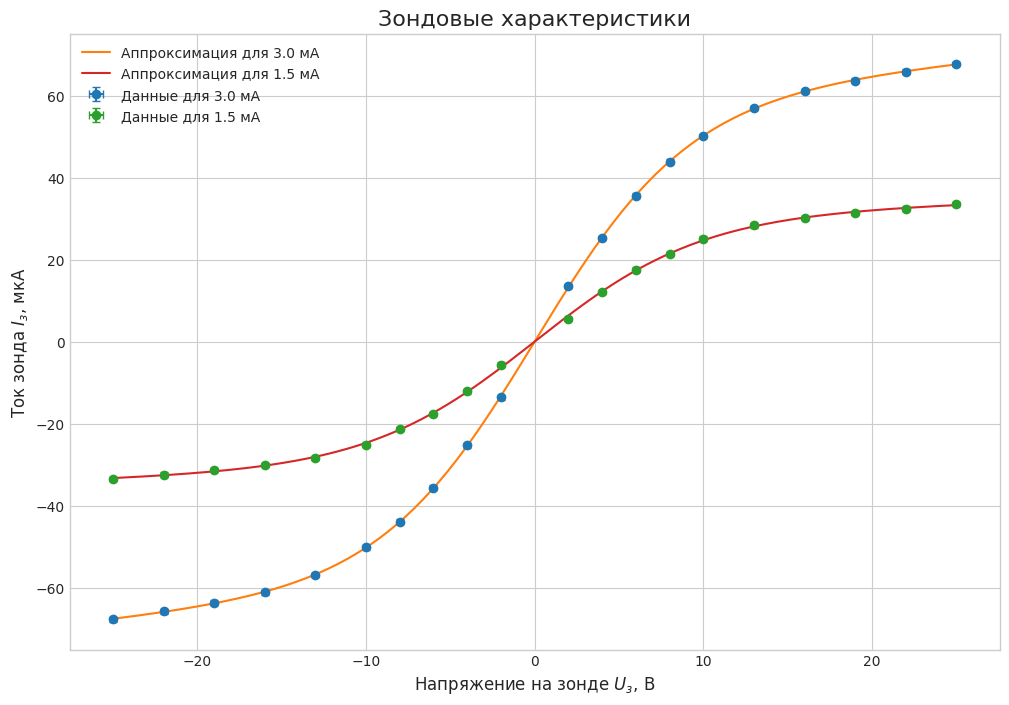

Результаты аппроксимации:

Для тока разряда I_p = 3.0 мА:
  Ионный ток насыщения: I_sat = 57.82 ± 1.92 мкА
  Температура электронов: T_e = 53.1 ± 1.5 тыс. K
  Температура электронов: T_e = 4.58 ± 0.13 эВ

Для тока разряда I_p = 1.5 мА:
  Ионный ток насыщения: I_sat = 30.53 ± 2.16 мкА
  Температура электронов: T_e = 57.1 ± 3.3 тыс. K
  Температура электронов: T_e = 4.93 ± 0.29 эВ


In [4]:
# --- Функция для аппроксимации ---
def probe_model(U, I_sat, T_e, A):
    return I_sat * np.tanh(e * U / (2 * k_b * T_e)) + A * U

results = {}
plt.figure(figsize=(12, 8))

# --- Аппроксимация и построение графиков ---
for label, df in datasets.items():
    U_V = df['U_z_V'].values
    I_A = df['I_z_uA'].values * 1e-6
    I_err_A = df['I_err'].values * 1e-6

    # Начальные приближения
    I_sat_guess = np.mean(np.abs(I_A[np.abs(U_V) > 20]))
    slope_guess = (I_A[-1] - I_A[-5]) / (U_V[-1] - U_V[-5]) if len(U_V) > 5 else 0
    p0 = [I_sat_guess, 30000, slope_guess] # T_e ~ 3 эВ

    # Аппроксимация
    params, cov = curve_fit(probe_model, U_V, I_A, p0=p0, sigma=I_err_A, absolute_sigma=True)
    errors = np.sqrt(np.diag(cov))
    
    # Сохранение результатов
    results[label] = {
        'I_sat_uA': params[0] * 1e6, 'I_sat_err': errors[0] * 1e6,
        'T_e_K': params[1], 'T_e_err': errors[1],
        'A': params[2], 'A_err': errors[2]
    }

    # Построение графика
    plt.errorbar(U_V, I_A * 1e6, yerr=df['I_err'], xerr=df['U_err'],
                 fmt='o', capsize=3, label=f'Данные для {label}')
    
    U_fit = np.linspace(min(U_V), max(U_V), 200)
    I_fit = probe_model(U_fit, *params) * 1e6
    plt.plot(U_fit, I_fit, '-', label=f'Аппроксимация для {label}')

plt.title('Зондовые характеристики', fontsize=16)
plt.xlabel('Напряжение на зонде $U_з$, В', fontsize=12)
plt.ylabel('Ток зонда $I_з$, мкА', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# --- Вывод результатов аппроксимации ---
result_df = pd.DataFrame(results).T
result_df['T_e_eV'] = result_df['T_e_K'] * k_b / e
result_df['T_e_eV_err'] = result_df['T_e_err'] * k_b / e

print("Результаты аппроксимации:")
for label, res in results.items():
    print(f"\nДля тока разряда I_p = {label}:")
    print(f"  Ионный ток насыщения: I_sat = {res['I_sat_uA']:.2f} ± {res['I_sat_err']:.2f} мкА")
    print(f"  Температура электронов: T_e = {res['T_e_K']/1e3:.1f} ± {res['T_e_err']/1e3:.1f} тыс. K")
    print(f"  Температура электронов: T_e = {res['T_e_K']*k_b/e:.2f} ± {res['T_e_err']*k_b/e:.2f} эВ")

#### 4. Расчет концентрации и других параметров плазмы

Используя полученные значения $I_{i, sat}$ и $T_e$, рассчитываем остальные параметры плазмы для каждого тока разряда.

**Концентрация электронов $n_e$:**
$$ n_e = \frac{I_{i, sat}}{0.4 \cdot e \cdot S \cdot \sqrt{\frac{2k_B T_e}{m_i}}} $$

**Плазменная частота $\omega_p$:**
$$ \omega_p = \sqrt{\frac{n_e e^2}{\varepsilon_0 m_e}} $$

**Дебаевский радиус $r_D$:**
$$ r_D = \sqrt{\frac{\varepsilon_0 k_B T_e}{n_e e^2}} $$

**Число частиц в сфере Дебая $N_D$:**
$$ N_D = \frac{4}{3}\pi r_D^3 n_e $$

,Температура Te (тыс. K),Концентрация ne (10^15 м⁻³),Плазменная частота (10^9 рад/с),Дебаевский радиус (мкм),Число в сфере Дебая
I_p (мА),,,,,
3.0,53.1 ± 1.5,43.60 ± 1.58,11.78 ± 0.21,76.2 ± 1.8,80700 ± 6320
1.5,57.1 ± 3.3,22.19 ± 1.70,8.40 ± 0.32,110.8 ± 5.3,126310 ± 20600


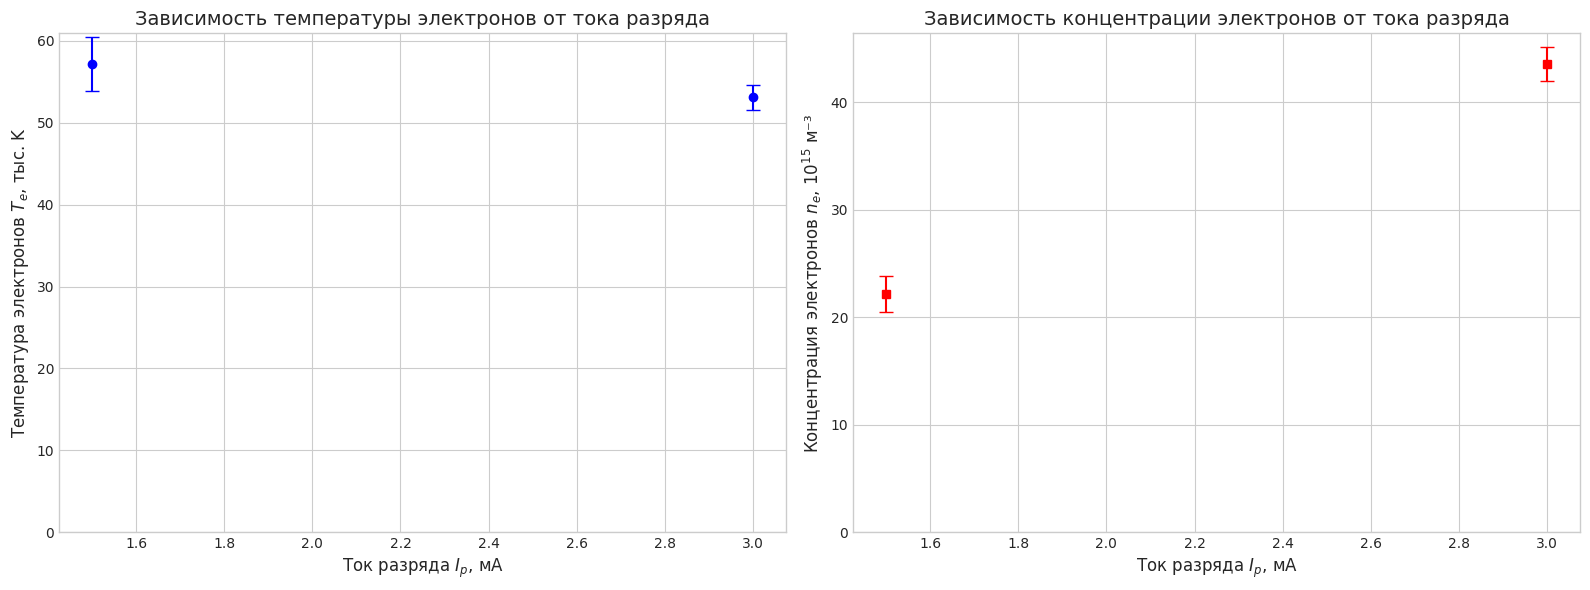

In [5]:
# --- Расчет остальных параметров плазмы ---
import pandas as pd
from IPython.display import display

# Списки для хранения вычисленных данных для графиков
I_p_vals_plot = []
Te_vals_plot = []
Te_errs_plot = []
ne_vals_plot = []
ne_errs_plot = []

final_params = []
for label, res in results.items():
    I_sat = res['I_sat_uA'] * 1e-6
    I_sat_err = res['I_sat_err'] * 1e-6
    T_e = res['T_e_K']
    T_e_err = res['T_e_err']

    # Расчет концентрации n_e
    C_ne = 1 / (0.4 * e * S_probe * np.sqrt(2 * k_b / m_i))
    n_e = C_ne * I_sat / np.sqrt(T_e)
    
    # Расчет погрешности n_e
    d_ne_d_I = C_ne / np.sqrt(T_e)
    d_ne_d_T = -0.5 * C_ne * I_sat / (T_e**1.5)
    n_e_err = np.sqrt((d_ne_d_I * I_sat_err)**2 + (d_ne_d_T * T_e_err)**2)
    
    # Расчет плазменной частоты omega_p
    omega_p = np.sqrt(n_e * e**2 / (epsilon_0 * m_e))
    omega_p_err = 0.5 * omega_p / n_e * n_e_err # (d_omega/d_n) * n_err
    
    # Расчет дебаевского радиуса r_D
    C_rd = np.sqrt(epsilon_0 * k_b / e**2)
    r_D = C_rd * np.sqrt(T_e / n_e)
    
    # Расчет погрешности r_D
    d_rd_d_T = 0.5 * r_D / T_e
    d_rd_d_n = -0.5 * r_D / n_e
    r_D_err = np.sqrt((d_rd_d_T * T_e_err)**2 + (d_rd_d_n * n_e_err)**2)
    
    # Расчет числа частиц в сфере Дебая N_D
    N_D = (4/3) * np.pi * (r_D**3) * n_e
    
    # Расчет погрешности N_D
    d_ND_d_rd = 3 * N_D / r_D
    d_ND_d_n = N_D / n_e
    N_D_err = np.sqrt((d_ND_d_rd * r_D_err)**2 + (d_ND_d_n * n_e_err)**2)
    
    # Добавляем результаты в список для таблицы с простыми русскими заголовками
    final_params.append({
        'I_p (мА)': float(label.split()[0]),
        'Температура Te (тыс. K)': f"{T_e/1e3:.1f} ± {T_e_err/1e3:.1f}",
        'Концентрация ne (10^15 м⁻³)': f"{n_e/1e15:.2f} ± {n_e_err/1e15:.2f}",
        'Плазменная частота (10^9 рад/с)': f"{omega_p/1e9:.2f} ± {omega_p_err/1e9:.2f}",
        'Дебаевский радиус (мкм)': f"{r_D*1e6:.1f} ± {r_D_err*1e6:.1f}",
        'Число в сфере Дебая': f"{int(round(N_D, -1))} ± {int(round(N_D_err, -1))}"
    })

    # Сохраняем данные для последующего построения графиков
    I_p_vals_plot.append(float(label.split()[0]))
    Te_vals_plot.append(T_e)
    Te_errs_plot.append(T_e_err)
    ne_vals_plot.append(n_e)
    ne_errs_plot.append(n_e_err)

# Создаем DataFrame и выводим его на экран (простой display отлично справится)
summary_df = pd.DataFrame(final_params).set_index('I_p (мА)')
display(summary_df)


# --- Построение графиков зависимостей ---

# Преобразуем списки с данными в массивы numpy для удобства
I_p_vals = np.array(I_p_vals_plot)
Te_vals = np.array(Te_vals_plot)
Te_errs = np.array(Te_errs_plot)
ne_vals = np.array(ne_vals_plot)
ne_errs = np.array(ne_errs_plot)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# График T_e(I_p)
ax1.errorbar(I_p_vals, Te_vals / 1e3, yerr=Te_errs / 1e3, fmt='o', capsize=5, color='blue')
ax1.set_title('Зависимость температуры электронов от тока разряда', fontsize=14)
ax1.set_xlabel('Ток разряда $I_p$, мА', fontsize=12)
ax1.set_ylabel('Температура электронов $T_e$, тыс. K', fontsize=12)
ax1.set_ylim(bottom=0)
ax1.grid(True)

# График n_e(I_p)
ax2.errorbar(I_p_vals, ne_vals / 1e15, yerr=ne_errs / 1e15, fmt='s', capsize=5, color='red')
ax2.set_title('Зависимость концентрации электронов от тока разряда', fontsize=14)
ax2.set_xlabel('Ток разряда $I_p$, мА', fontsize=12)
ax2.set_ylabel('Концентрация электронов $n_e$, $10^{15}$ м⁻³', fontsize=12)
ax2.set_ylim(bottom=0)
ax2.grid(True)

plt.tight_layout()
plt.show()